# Right-hand Side Learning of Lorenz 63 with Tests

device: mps
ep     1 | loss = 3.068e+03
ep  1000 | loss = 6.435e+02
ep  2000 | loss = 2.653e+02
ep  3000 | loss = 1.291e+02
ep  4000 | loss = 6.726e+01
ep  5000 | loss = 3.490e+01
ep  6000 | loss = 1.825e+01
ep  7000 | loss = 8.276e+00
ep  8000 | loss = 3.172e+00


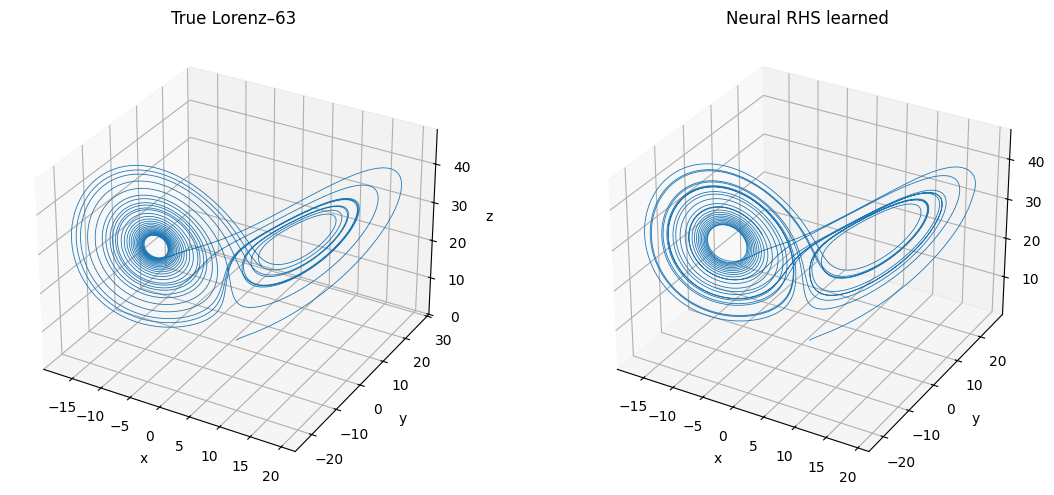

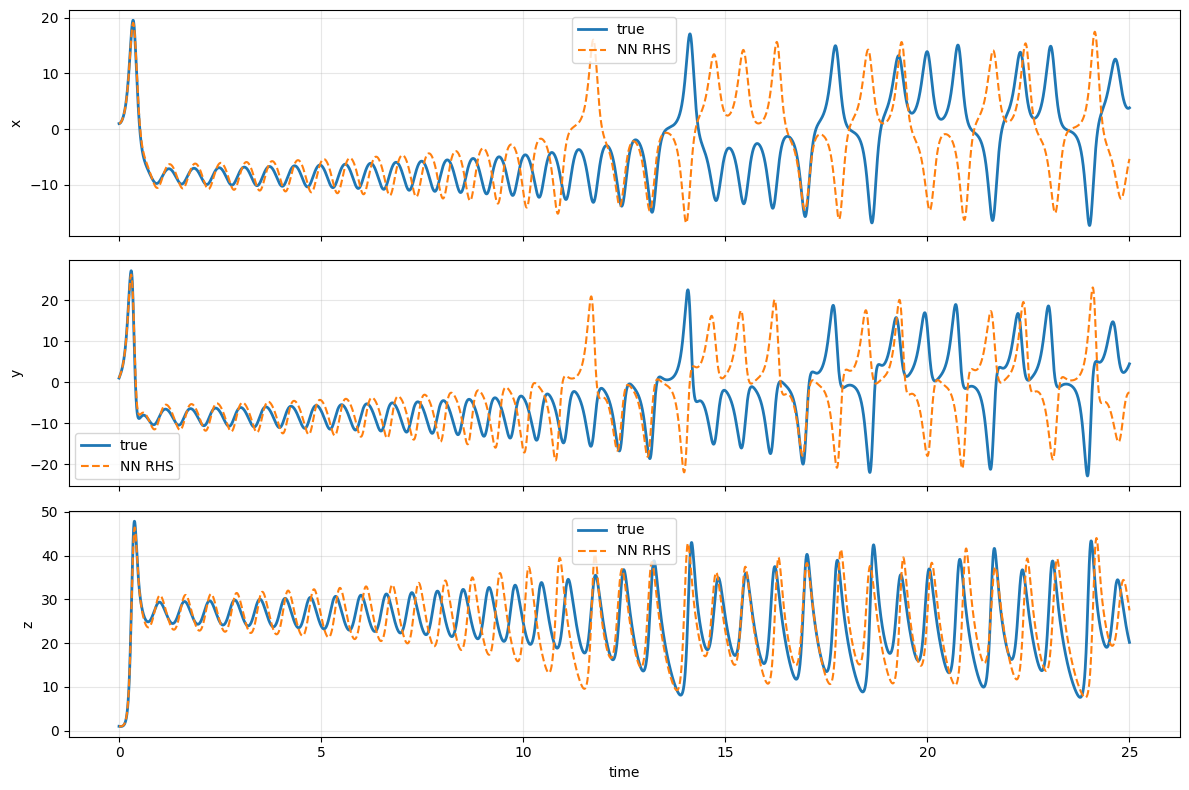

Saved: rhs_learning1.png, rhs_learning2.png


In [1]:
# ============================================================
# Neural RHS learning for Lorenz-63
# Learn full vector field f_theta(x,y,z)
# Save:
#   (a) 3D trajectory comparison  -> rhs_learning1.png
#   (b) x,y,z time series compare -> rhs_learning2.png
# ============================================================

import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ------------------------------------------------------------
# Reproducibility + device
# ------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("device:", device)

# ------------------------------------------------------------
# True Lorenz-63 system
# ------------------------------------------------------------
sigma, rho, beta = 10.0, 28.0, 8.0/3.0

def lorenz63(t, X):
    x, y, z = X
    return [
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z
    ]

# ------------------------------------------------------------
# Generate training data
# ------------------------------------------------------------
x0 = [1.0, 1.0, 1.0]
t_span = (0.0, 25.0)
t_eval = np.linspace(*t_span, 5000)

sol = solve_ivp(lorenz63, t_span, x0, t_eval=t_eval, rtol=1e-10)
X = sol.y.T

dt = t_eval[1] - t_eval[0]
dXdt = np.gradient(X, dt, axis=0)

X_t = torch.tensor(X, dtype=torch.float32, device=device)
dXdt_t = torch.tensor(dXdt, dtype=torch.float32, device=device)

# ------------------------------------------------------------
# Neural network for RHS learning
# ------------------------------------------------------------
class RHSNet(nn.Module):
    def __init__(self, width=128, depth=4):
        super().__init__()
        layers = [nn.Linear(3, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 3)]
        self.net = nn.Sequential(*layers)

        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model = RHSNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# ------------------------------------------------------------
# Training loop
# ------------------------------------------------------------
epochs = 8000
for ep in range(1, epochs + 1):
    opt.zero_grad()
    pred = model(X_t)
    loss = torch.mean((pred - dXdt_t)**2)
    loss.backward()
    opt.step()

    if ep % 1000 == 0 or ep == 1:
        print(f"ep {ep:5d} | loss = {loss.item():.3e}")

# ------------------------------------------------------------
# Integrate learned RHS
# ------------------------------------------------------------
def rhs_nn(t, X):
    X_t = torch.tensor(X, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        dX = model(X_t).cpu().numpy()[0]
    return dX.tolist()

sol_nn = solve_ivp(
    rhs_nn, t_span, x0, t_eval=t_eval, rtol=1e-10
)

# ------------------------------------------------------------
# (a) 3D trajectory comparison
# ------------------------------------------------------------
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection="3d")
ax1.plot(X[:,0], X[:,1], X[:,2], lw=0.6)
ax1.set_title("True Lorenz–63")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")

ax2 = fig.add_subplot(122, projection="3d")
ax2.plot(sol_nn.y[0], sol_nn.y[1], sol_nn.y[2], lw=0.6)
ax2.set_title("Neural RHS learned")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")

plt.tight_layout()
plt.savefig("rhs_learning1.png", dpi=200)
plt.show()

# ------------------------------------------------------------
# (b) Time series comparison
# ------------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

labels = ["x", "y", "z"]
for i, ax in enumerate(axes):
    ax.plot(t_eval, X[:,i], label="true", lw=2)
    ax.plot(t_eval, sol_nn.y[i], "--", label="NN RHS", lw=1.5)
    ax.set_ylabel(labels[i])
    ax.grid(alpha=0.3)
    ax.legend()

axes[-1].set_xlabel("time")

plt.tight_layout()
plt.savefig("rhs_learning2.png", dpi=200)
plt.show()

print("Saved: rhs_learning1.png, rhs_learning2.png")


# Learn Right-hand Side in the whole space

device: mps

Training RHS on full state space...
ep     1 | loss = 6.566e+04
ep  1000 | loss = 4.055e+04
ep  2000 | loss = 2.882e+04
ep  3000 | loss = 1.960e+04
ep  4000 | loss = 1.349e+04
ep  5000 | loss = 8.645e+03
ep  6000 | loss = 5.775e+03
ep  7000 | loss = 4.259e+03
ep  8000 | loss = 2.455e+03
ep  9000 | loss = 1.734e+03
ep 10000 | loss = 1.087e+03
ep 11000 | loss = 6.705e+02
ep 12000 | loss = 3.637e+02
ep 13000 | loss = 1.590e+02
ep 14000 | loss = 1.272e+02
ep 15000 | loss = 8.346e+01
ep 16000 | loss = 3.862e+01
ep 17000 | loss = 2.624e+01
ep 18000 | loss = 1.591e+01
ep 19000 | loss = 1.594e+01
ep 20000 | loss = 7.166e+00
ep 21000 | loss = 8.179e+00
ep 22000 | loss = 5.825e+00
ep 23000 | loss = 9.097e+00
ep 24000 | loss = 7.440e+00
ep 25000 | loss = 1.926e+01


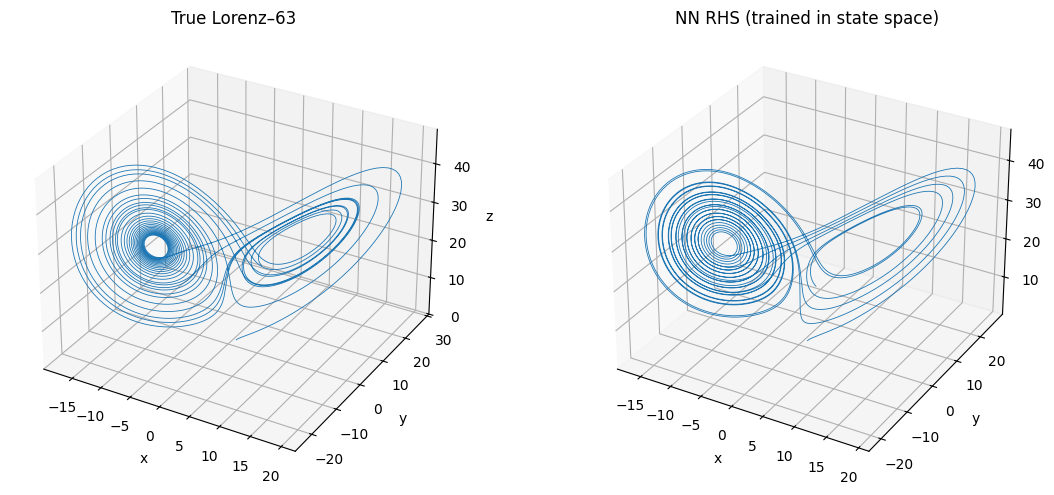

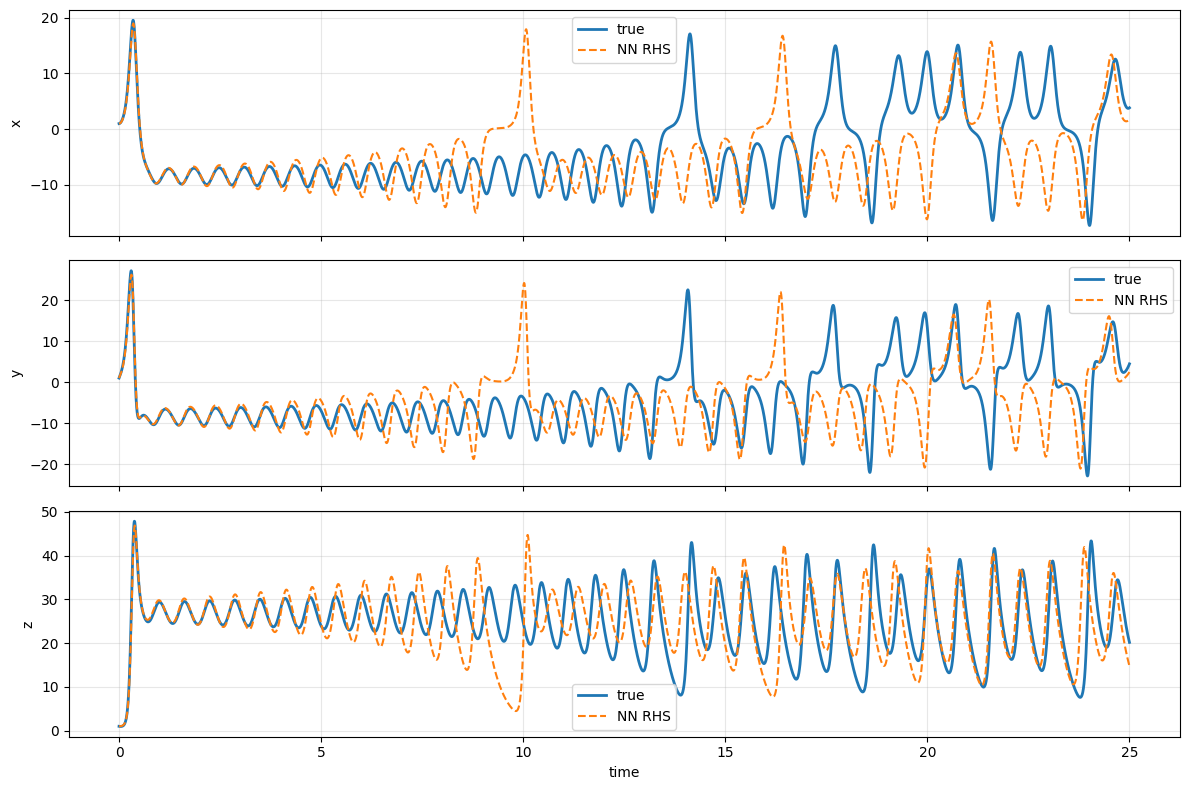

Saved: rhs_learning_space_1.png, rhs_learning_space_2.png


In [3]:
# ============================================================
# Neural RHS learning with FULL STATE-SPACE SAMPLING
# Lorenz-63 vector field learned in R^3, not only on trajectory
# Saves:
#   (a) rhs_learning_space_1.png  (3D trajectory)
#   (b) rhs_learning_space_2.png  (time series x,y,z)
# ============================================================

import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ------------------------------------------------------------
# Reproducibility + device
# ------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("device:", device)

# ------------------------------------------------------------
# True Lorenz-63 RHS
# ------------------------------------------------------------
sigma, rho, beta = 10.0, 28.0, 8.0/3.0

def lorenz63_rhs(X):
    x, y, z = X[:,0], X[:,1], X[:,2]
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.stack([dx, dy, dz], axis=1)

# ------------------------------------------------------------
# Sample FULL STATE SPACE
# ------------------------------------------------------------
N_samples = 60000

# Bounding box covering Lorenz attractor + margin
x_range = [-25, 25]
y_range = [-35, 35]
z_range = [0, 50]

X_space = np.column_stack([
    np.random.uniform(*x_range, size=N_samples),
    np.random.uniform(*y_range, size=N_samples),
    np.random.uniform(*z_range, size=N_samples),
])

dXdt_space = lorenz63_rhs(X_space)

X_t = torch.tensor(X_space, dtype=torch.float32, device=device)
dXdt_t = torch.tensor(dXdt_space, dtype=torch.float32, device=device)

# ------------------------------------------------------------
# Neural RHS model
# ------------------------------------------------------------
class RHSNet(nn.Module):
    def __init__(self, width=128, depth=4):
        super().__init__()
        layers = [nn.Linear(3, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 3)]
        self.net = nn.Sequential(*layers)

        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model = RHSNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# ------------------------------------------------------------
# Training
# ------------------------------------------------------------
epochs = 25000
batch_size = 4096

print("\nTraining RHS on full state space...")
for ep in range(1, epochs + 1):
    idx = torch.randint(0, N_samples, (batch_size,))
    Xb = X_t[idx]
    dXb = dXdt_t[idx]

    opt.zero_grad()
    pred = model(Xb)
    loss = torch.mean((pred - dXb)**2)
    loss.backward()
    opt.step()

    if ep % 1000 == 0 or ep == 1:
        print(f"ep {ep:5d} | loss = {loss.item():.3e}")

# ------------------------------------------------------------
# Test: integrate learned RHS
# ------------------------------------------------------------
def rhs_nn(t, X):
    Xt = torch.tensor(X, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        dX = model(Xt).cpu().numpy()[0]
    return dX.tolist()

x0 = [1.0, 1.0, 1.0]
t_span = (0.0, 25.0)
t_eval = np.linspace(*t_span, 5000)

sol_true = solve_ivp(
    lambda t, X: lorenz63_rhs(np.array(X)[None,:])[0],
    t_span, x0, t_eval=t_eval, rtol=1e-10
)

sol_nn = solve_ivp(
    rhs_nn, t_span, x0, t_eval=t_eval, rtol=1e-10
)

# ------------------------------------------------------------
# (a) 3D trajectory comparison
# ------------------------------------------------------------
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection="3d")
ax1.plot(sol_true.y[0], sol_true.y[1], sol_true.y[2], lw=0.6)
ax1.set_title("True Lorenz–63")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")

ax2 = fig.add_subplot(122, projection="3d")
ax2.plot(sol_nn.y[0], sol_nn.y[1], sol_nn.y[2], lw=0.6)
ax2.set_title("NN RHS (trained in state space)")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")

plt.tight_layout()
plt.savefig("rhs_learning_space_1.png", dpi=200)
plt.show()

# ------------------------------------------------------------
# (b) Time series comparison
# ------------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

labels = ["x", "y", "z"]
for i, ax in enumerate(axes):
    ax.plot(t_eval, sol_true.y[i], label="true", lw=2)
    ax.plot(t_eval, sol_nn.y[i], "--", label="NN RHS", lw=1.5)
    ax.set_ylabel(labels[i])
    ax.grid(alpha=0.3)
    ax.legend()

axes[-1].set_xlabel("time")

plt.tight_layout()
plt.savefig("rhs_learning_space_2.png", dpi=200)
plt.show()

print("Saved: rhs_learning_space_1.png, rhs_learning_space_2.png")


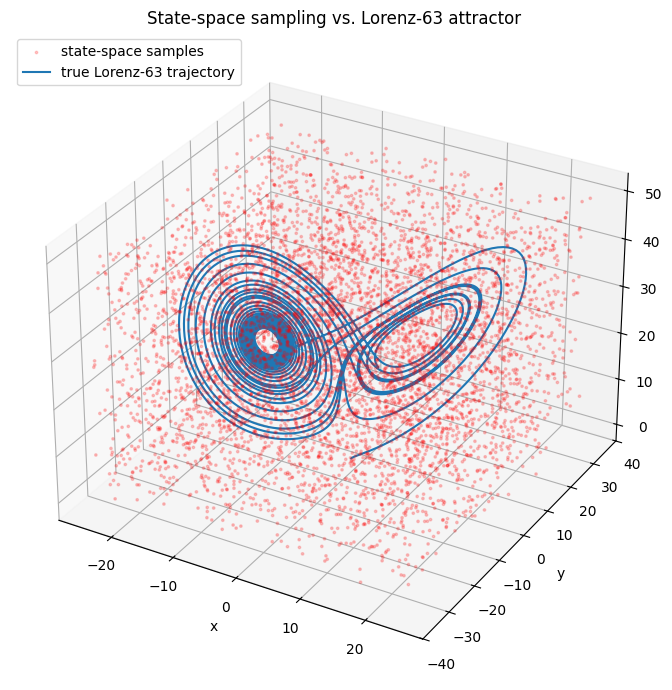

Saved: rhs_learning_space_sampling.png


In [5]:
# ============================================================
# Visualize state-space sampling + true Lorenz-63 trajectory
# Saves: rhs_learning_space_sampling.png
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

# ------------------------------------------------------------
# Lorenz-63 system
# ------------------------------------------------------------
sigma, rho, beta = 10.0, 28.0, 8.0/3.0

def lorenz63(t, X):
    x, y, z = X
    return [
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z
    ]

# ------------------------------------------------------------
# Generate true trajectory
# ------------------------------------------------------------
x0 = [1.0, 1.0, 1.0]
t_span = (0.0, 25.0)
t_eval = np.linspace(*t_span, 6000)

sol = solve_ivp(
    lorenz63, t_span, x0,
    t_eval=t_eval, rtol=1e-10
)
X_true = sol.y.T

# ------------------------------------------------------------
# State-space sampling (same as RHS-learning cell)
# ------------------------------------------------------------
np.random.seed(0)
N_samples = 60000

x_range = [-25, 25]
y_range = [-35, 35]
z_range = [0, 50]

X_space = np.column_stack([
    np.random.uniform(*x_range, size=N_samples),
    np.random.uniform(*y_range, size=N_samples),
    np.random.uniform(*z_range, size=N_samples),
])

# Subsample for visualization clarity
idx = np.random.choice(N_samples, size=6000, replace=False)
Xs = X_space[idx]

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

# State-space samples
ax.scatter(
    Xs[:, 0], Xs[:, 1], Xs[:, 2],
    s=3, alpha=0.20, color="red",
    label="state-space samples"
)

# True Lorenz trajectory
ax.plot(
    X_true[:, 0], X_true[:, 1], X_true[:, 2],
    color="tab:blue", linewidth=1.5,
    label="true Lorenz-63 trajectory"
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("State-space sampling vs. Lorenz-63 attractor")

ax.legend(loc="upper left")
plt.tight_layout()
plt.savefig("rhs_learning_space_sampling.png", dpi=200)
plt.show()

print("Saved: rhs_learning_space_sampling.png")
